Plotting 2m air temperature for all DYAMOND WINTER simulations
-----------------------------------------------------------------------------

The variable to be plotted is set in 'var' in the third field.


**Note, this script is anything but pretty. The grids in the DYAMOND WINTER simulations are quite diverse, so some nasty steps were necessary to process all of them in a similar fashion**


Copyright 2021 Florian Ziemen <ziemen@dkrz.de>.
This program is free software: you can redistribute it and/or modify it under the terms of the BSD-3-Clause license (see bottom for details).

In [1]:
import intake
import xarray as xr
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import cartopy.crs as crs
import pandas as pd
from datashader.mpl_ext import dsshow
import datashader as ds
import dask

dask.config.set(
    **{"array.slicing.split_large_chunks": True}
)  # removes an warning, but does not really change anything here.

import warnings, matplotlib

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)


def fix_time_axis(data):
    """Turn icon's yyyymmdd.f time axis into actual datetime format.

    This will fail for extreme values, but should be fine for a few centuries around today.
    """
    try:
        if (data.time.dtype != "datetime64[ns]") and (
            data["time"].units == "day as %Y%m%d.%f"
        ):
            data["time"] = pd.to_datetime(
                ["%8i" % x for x in data.time], format="%Y%m%d"
            ) + pd.to_timedelta([x % 1 for x in data.time.values], unit="d")
    except:
        print("Could not manipulate time axis. Assuming it's ok", file=sys.stderr)


def get_from_cat(catalog, columns):
    """A helper function for inspecting an intake catalog.

    Call with the catalog to be inspected and a list of columns of interest."""

    if type(columns) == type(""):
        columns = [columns]
    return catalog.df[columns].drop_duplicates().sort_values(columns)

In [2]:
col_url = "/work/ka1081/Catalogs/dyamond-nextgems.json"
col = intake.open_esm_datastore(col_url)

col
# col.unique()['variable']

,unique
variable_id,546
project,2
institution_id,12
source_id,19
experiment_id,4
simulation_id,12
realm,5
frequency,12
time_reduction,4
grid_label,7


In [3]:
var = "tas"
cat = col.search(
    project="DYAMOND_WINTER",
    # institute="ECMWF",
    variable_id=var,
    frequency=["15min", "1hr", "30min", "3hr", "12hr"]
    #              time_min="2020-02-05T00:00:00.000"
    #   grid="gn"
)

get_from_cat(cat, ["source_id", "experiment_id", "simulation_id", "frequency"])

,source_id,experiment_id,simulation_id,frequency
204,ARPEGE-NH-2km,DW-ATM,r1i1p1f1,15min
40,GEM,DW-ATM,r1i1p1f1,1hr
411,GEOS-3km,DW-ATM,r1i1p1f1,15min
541,GEOS-6km,DW-CPL,r1i1p1f1,15min
246,ICON-NWP-2km,DW-ATM,r1i1p1f1,15min
288,ICON-SAP-5km,DW-ATM,dpp0014,15min
330,ICON-SAP-5km,DW-CPL,dpp0029,15min
81,IFS-4km,DW-CPL,r1i1p1f1,1hr
122,IFS-9km,DW-CPL,r1i1p1f1,1hr
0,NICAM-3km,DW-ATM,r1i1p1f1,15min


In [4]:
cat_dict = cat.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.simulation_id.realm.frequency.time_reduction.grid_label.level_type'


In [5]:
def name2dict(cat, name):
    keys = cat.groupby_attrs
    values = name.split(".")
    ret = dict(zip(keys, values))
    #    print(ret)
    return ret


def guess_grid_file(cat, name):
    nd = name2dict(
        cat, name
    )  # /work/ka1081/DYAMOND_WINTER/MPIM-DWD-DKRZ/ICON-SAP-5km/DW-CPL/atmos/fx/gn/
    return "/work/ka1081/{project}/{institution_id}/{source_id}/{experiment_id}/{realm}/fx/{grid_label}/grid.nc".format(
        **nd
    )

In [6]:
def get_coords(cat, cat_dict, x, var):
    root = "/work/ka1081/"
    end = "/grid.nc"
    lat = None
    lon = None
    grid = None
    print("Processing " + x)
    components = x.split(".")
    image_filename = "tas_" + x + ".png"
    try:
        grid_file_name = guess_grid_file(cat, x)
        grid = xr.open_dataset(grid_file_name)
        ds = xr.merge([cat_dict[x], grid])
        print("loaded grid from file " + grid_file_name)
    except:
        print("could not open a grid file at " + grid_file_name)
        ds = cat_dict[x]
    lat, lon = guess_coords(ds, var)
    print("got coordinates")
    if lat.max() < 4:
        print("converting radian to degree")
        lat = np.rad2deg(lat)
        lon = np.rad2deg(lon)
        lat["units"] = "degree"
        lon["units"] = "degree"

    if lon.max() > 180:
        print("shifting from 0 to 360 to -180 to 180")
        lon = lon - (360 * (lon > 180))
    #    print ("max lon ", lon.max())
    return (ds, lat, lon)


def guess_coords(ds, var):
    try:
        #        print (ds[var].coordinates)
        lon, lat = [ds[x] for x in ds[var].coordinates.split()]
        print(
            "using "
            + ds[var].coordinates
            + " from coordinates attribute as coordinates."
        )
    except:
        lat = None
        lon = None
        try:
            lon = ds.clon
            lat = ds.clat
            print("using clat and clon directly.")
        except:
            try:
                lon = ds.lon
                lat = ds.lat
            except:
                lat = None
                lon = None
                try:
                    for co in ds[var].coords.keys():
                        print("trying variables from coords property " + co)
                        if "lon" in co:
                            print("found " + co + " for *lon*.")
                            lon = ds[co]
                        if "lat" in co:
                            print("found " + co + " for *lat*.")
                            lat = ds[co]
                    lat.shape
                except:
                    lat = None
                    lon = None

                    lon = ds[ds[var].dims[-1]]
                    lat = ds[ds[var].dims[-2]]
                    print("using " + ds[var].dims[-1] + " as lon")
                    print("using " + ds[var].dims[-2] + " as lat")
    return (lat, lon)

In [7]:
def flatten_if_necessary(data, lat, lon, time):
    if lon.shape[-1] != data.shape[-1] or lat.shape[-1] != data.shape[-1]:
        print(
            "assuming the grid to be lat x lon as last dim of coordinate does not match last dim of shape of data:"
        )
        if lon.shape[-1] != data.shape[-1]:
            print("lon != data: ", lon.shape[-1], " != ", data.shape[-1])
        if lat.shape[-1] != data.shape[-1]:
            print("lat != data: ", lat.shape[-1], " != ", data.shape[-1])

        lon, lat = np.meshgrid(lon, lat)
        #        print(ds.tas[0][5].shape)
        lon = lon.flatten()
        lat = lat.flatten()
        dflat = np.array(np.squeeze(data.sel(time=time))).flatten()
    else:
        print("assuming full field variables for lat and lon")
        lon = np.array(lon).flatten()
        lat = np.array(lat).flatten()
        dflat = np.array(np.squeeze(data.sel(time=time))).flatten()
    return dflat, lat, lon


def transform_coords(data, lat, lon, projection):
    """Projects coordinates of the dataset into the desired map projection.

    Expects data.lon to be the longitudes and data.lat to be the latitudes

    """
    coords = (
        projection.transform_points(  # This re-projects our data to the desired grid.
            crs.Geodetic(), lon, lat
        )
    )
    return coords


def plot_map(
    data,
    lat,
    lon,
    projection,
    coords=None,  # we can compute them ourselves, if given data with lat and lon attached.
    colorbar_label="",
    title="",
    coastlines=True,
    extent=None,
    **kwargs,
):
    """Use datashader to plot a dataset from a pandas dataframe with a given projection.

    Required: data, lat, lon and projection.
    All other arguments are optional. Additional arguments will be passed directly to the plot routine (dsshow).
    """

    # If we are not given projected data, we project it ourselves.
    if coords is None:
        coords = transform_coords(data, lat, lon, projection)

    # For datashader, we need the data in a pandas dataframe object.
    df = pd.DataFrame(
        data={
            "val": np.squeeze(
                data
            ),  # here we select which data to plot! - the squeeze removes empty dimensions.
            "x": coords[:, 0],  # from the projection above
            "y": coords[:, 1],  # from the projection above
        }
    )

    # the basis for map plotting.
    fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={"projection": projection})
    fig.canvas.draw_idle()  # necessary to make things work

    # the plot itself
    artist = dsshow(df, ds.Point("x", "y"), ds.mean("val"), ax=ax, **kwargs)

    # making things pretty
    plt.title(title)
    if coastlines:
        ax.coastlines(color="grey")
    fig.colorbar(artist, label=colorbar_label)

    # for regional plots:
    if extent is not None:
        ax.set_extent(extent)

    return fig

In [8]:
ts = "2020-02-05T12:00:00"

projection = crs.Mollweide()


def plot_fields(cat, cat_dict, x, var, vmin=240, vmax=300):
    ds, lat, lon = get_coords(cat, cat_dict, x, var)
    fix_time_axis(ds)
    dflat, lat, lon = flatten_if_necessary(ds[var], lat, lon, ts)
    name = ".".join(x.split(".")[1:5]) + ".{x.split('.')[6]}"
    plot_map(
        dflat,
        lat,
        lon,
        projection,
        cmap="inferno",
        vmin=vmin,
        vmax=vmax,
        title=f"{name}\n{ts}",
        colorbar_label="Near-surface air temperature (K)",
    )
    image_filename = var + "_" + x + ".png"
    plt.savefig(image_filename)


#    plt.close()


Processing DYAMOND_WINTER.MPIM-DWD-DKRZ.ICON-SAP-5km.DW-CPL.dpp0029.atmos.15min.unknown.gn.2d
loaded grid from file /work/ka1081/DYAMOND_WINTER/MPIM-DWD-DKRZ/ICON-SAP-5km/DW-CPL/atmos/fx/gn/grid.nc
using clon clat from coordinates attribute as coordinates.
got coordinates
converting radian to degree
assuming full field variables for lat and lon

Processing DYAMOND_WINTER.MPIM-DWD-DKRZ.ICON-SAP-5km.DW-ATM.dpp0014.atmos.15min.unknown.gn.2d
loaded grid from file /work/ka1081/DYAMOND_WINTER/MPIM-DWD-DKRZ/ICON-SAP-5km/DW-ATM/atmos/fx/gn/grid.nc
using clon clat from coordinates attribute as coordinates.
got coordinates
converting radian to degree
assuming full field variables for lat and lon

Processing DYAMOND_WINTER.NASA.GEOS-3km.DW-ATM.r1i1p1f1.atmos.15min.unknown.gn.2d
could not open a grid file at /work/ka1081/DYAMOND_WINTER/NASA/GEOS-3km/DW-ATM/atmos/fx/gn/grid.nc
trying variables from coords property time
trying variables from coords property lons
found lons for *lon*.
trying variabl

Could not manipulate time axis. Assuming it's ok


assuming full field variables for lat and lon

Processing DYAMOND_WINTER.MetOffice.UM-5km.DW-ATM.r1i1p1f1.atmos.15min.unknown.gn.2d
could not open a grid file at /work/ka1081/DYAMOND_WINTER/MetOffice/UM-5km/DW-ATM/atmos/fx/gn/grid.nc
trying variables from coords property time
trying variables from coords property longitude
found longitude for *lon*.
trying variables from coords property latitude
found latitude for *lat*.
got coordinates
shifting from 0 to 360 to -180 to 180
assuming the grid to be lat x lon as last dim of coordinate does not match last dim of shape of data:
lat != data:  3840  !=  5120

Processing DYAMOND_WINTER.AORI.NICAM-3km.DW-ATM.r1i1p1f1.atmos.15min.unknown.gn.2d
could not open a grid file at /work/ka1081/DYAMOND_WINTER/AORI/NICAM-3km/DW-ATM/atmos/fx/gn/grid.nc
got coordinates
shifting from 0 to 360 to -180 to 180
assuming the grid to be lat x lon as last dim of coordinate does not match last dim of shape of data:
lat != data:  5120  !=  10240

Processing DYAMOND_

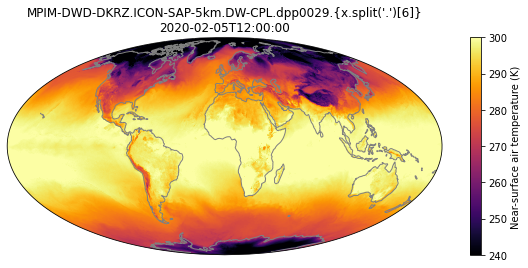

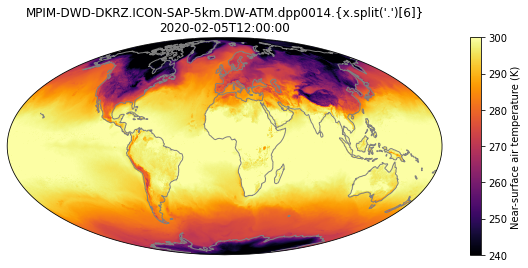

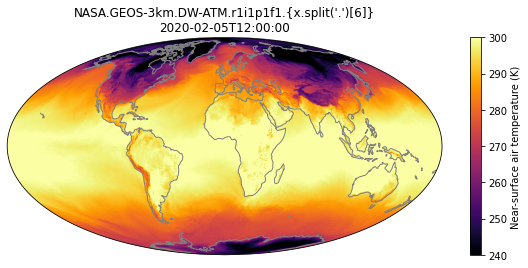

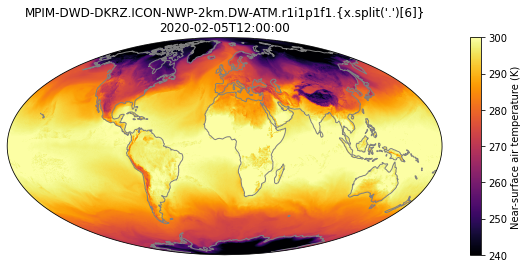

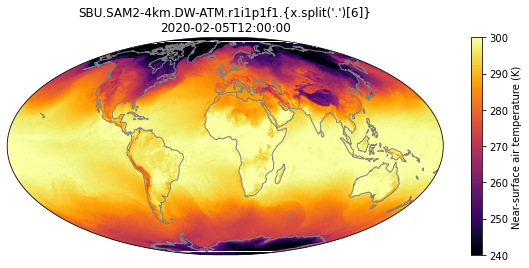

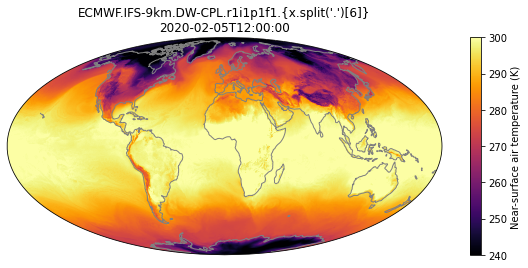

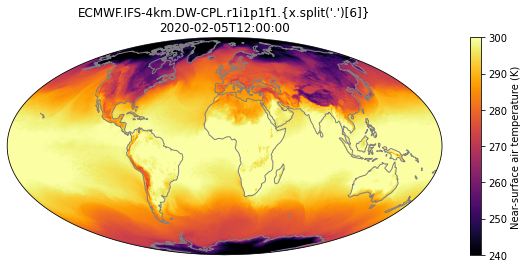

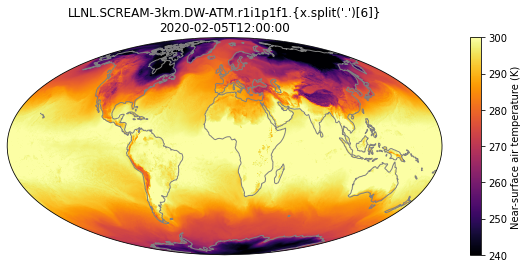

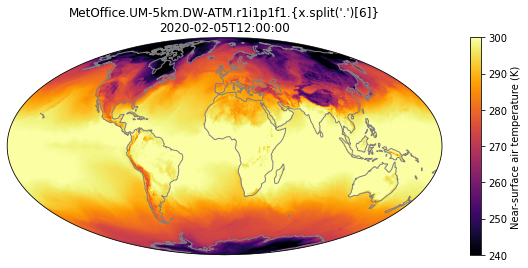

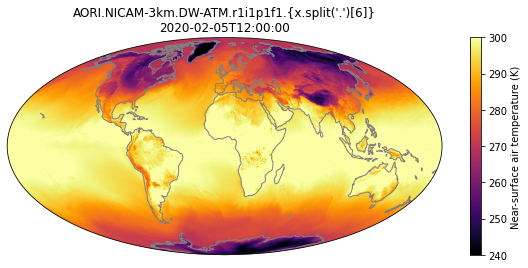

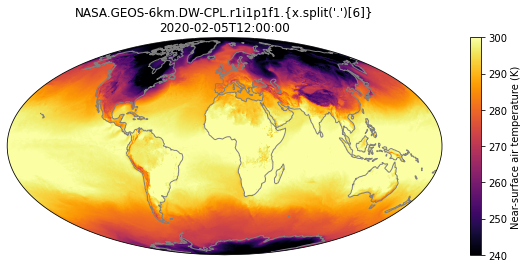

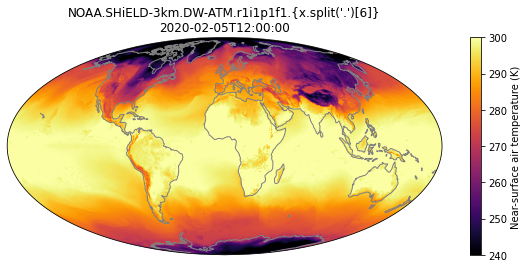

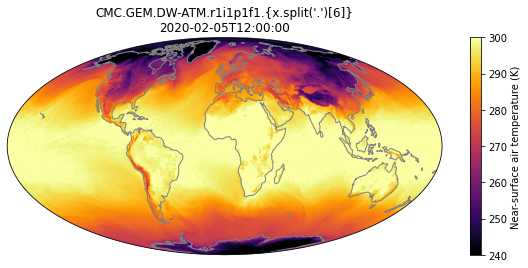

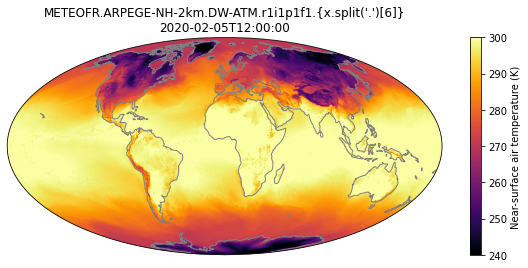

In [9]:
for x in cat_dict.keys():
    print("")
    if "." in x:
        #        try:
        plot_fields(cat, cat_dict, x, var, vmin=240, vmax=300)
#        except e:
#            print ("can't plot ", x, e )

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
* Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS “AS IS” AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.